## - Import

In [1]:
!pip install pytransform3d

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [4]:
import dataset
from dataset.panoptic import JointsDataset

## - Panoptic Dataset

In [5]:
data_name = 'panoptic'
# 'train', 'valid'
model_name = 'faster_voxelpose'
root_id = 2
max_people = 10
color_rgb = True
dataset_dir = './data/panoptic'
ori_image_size = [1920, 1080]
image_size = [960, 512]
heatmap_size = [240, 128]
cam_list = [i for i in range(31)] #[3, 6, 12, 13, 23]
num_views = len(cam_list)
sigma = 3
space_size = [8000.0, 8000.0, 2000.0]
space_center = [0.0, -500.0, 800.0]
voxels_per_axis = [80, 80, 20]
individual_space_size = [2000, 2000, 2000]
is_train = True

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
            transforms.ToTensor(),
            normalize])

In [7]:
dataset = eval('dataset.' + data_name)(
        model_name, root_id, max_people, num_views, color_rgb, dataset_dir, cam_list, \
        ori_image_size, image_size, heatmap_size, \
        sigma, space_size, space_center, voxels_per_axis, individual_space_size, \
        is_train=is_train, transform=transform)

In [8]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

## - Camera Parameters

In [9]:
cameras = loader.dataset.cameras

In [10]:
cameras.keys()

dict_keys(['160422_ultimatum1', '160224_haggling1', '160226_haggling1', '161202_haggling1', '160906_ian1', '160906_ian2', '160906_ian3', '160906_band1', '160906_band2'])

## - Util Function
    - References
        - https://towardsdatascience.com/camera-extrinsic-matrix-with-example-in-python-cfe80acab8dd
        - https://github.com/wingedrasengan927/Image-formation-and-camera-calibration/blob/master/utils.py

In [11]:
# def get_rot_x(angle):
#     '''
#     transformation matrix that rotates a point about the standard X axis
#     '''
#     Rx = np.zeros(shape=(3, 3))
#     Rx[0, 0] = 1
#     Rx[1, 1] = np.cos(angle)
#     Rx[1, 2] = -np.sin(angle)
#     Rx[2, 1] = np.sin(angle)
#     Rx[2, 2] = np.cos(angle)
    
#     return Rx

# def get_rot_y(angle):
#     '''
#     transformation matrix that rotates a point about the standard Y axis
#     '''
#     Ry = np.zeros(shape=(3, 3))
#     Ry[0, 0] = np.cos(angle)
#     Ry[0, 2] = -np.sin(angle)
#     Ry[2, 0] = np.sin(angle)
#     Ry[2, 2] = np.cos(angle)
#     Ry[1, 1] = 1
    
#     return Ry

# def get_rot_z(angle):
#     '''
#     transformation matrix that rotates a point about the standard Z axis
#     '''
#     Rz = np.zeros(shape=(3, 3))
#     Rz[0, 0] = np.cos(angle)
#     Rz[0, 1] = -np.sin(angle)
#     Rz[1, 0] = np.sin(angle)
#     Rz[1, 1] = np.cos(angle)
#     Rz[2, 2] = 1
    
#     return Rz

In [12]:
# def create_rotation_transformation_matrix(angles, order):
#     '''
#     Create a matrix that rotates a vector through the given angles in the given order
#     wrt the standard global axes (extrinsic rotation)
#     Note: The rotation is carried out anti-clockwise in a left handed axial system
    
#     Parameters
#     -----------
#     angles - list
#         list of angles in radians
#     order - string
#         the order in which to rotate
        
#     Returns
#     --------
#     net - np.ndarray, shape - (3, 3)
#         The transformation matrix which carries out the given rotations
#     '''
#     fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
#     net = np.identity(3)
#     for angle, axis in list(zip(angles, order))[::-1]:
#         if fn_mapping.get(axis) is None:
#             raise ValueError("Invalid axis")
#         R = fn_mapping.get(axis)
#         net = np.matmul(net, R(angle))
        
#     return net

In [13]:
# def create_translation_matrix(offset):
#     '''
#     Create a transformation matrix that translates a vetor by the given offset
    
#     Parameters
#     -----------
#     offset - np.ndarray, shape - (3,)
#         The translation offset
    
#     Returns
#     ----------
#     T - np.ndarray, shape - (4, 4)
#         The translation matrix
#     '''
#     T = np.identity(4)
#     T[:3, 3] = offset
#     return T

In [14]:
# def create_image_grid(focal_length, image_size):
#     '''
#     Create an image grid of the given size parallel to the XY plane
#     at a distance focal length from the camera center (origin)
#     '''
# #     h, w = image_size
#     w, h = image_size
#     xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
#     Z = np.ones(shape=(h,w)) * focal_length

#     return xx, yy, Z

In [15]:
# def convert_grid_to_homogeneous(xx, yy, Z, image_size):
#     '''
#     Extract coordinates from a grid and convert them to homogeneous coordinates
#     '''
# #     h, w = image_size
#     w, h = image_size
#     pi = np.ones(shape=(4, h*w))
#     c = 0
#     for i in range(h):
#         for j in range(w):
#             x = xx[i, j]
#             y = yy[i, j]
#             z = Z[i, j]
#             point = np.array([x, y, z])
#             pi[:3, c] = point
#             c += 1
#     return pi

In [16]:
# def convert_homogeneous_to_grid(pts, image_size):
#     '''
#     Convert a set of homogeneous points to a grid
#     '''
#     xxt = pts[0, :].reshape(image_size)
#     yyt = pts[1, :].reshape(image_size)
#     Zt = pts[2, :].reshape(image_size)

#     return xxt, yyt, Zt

In [17]:
def compute_intrinsic_parameter_matrix(fx, fy, s, cx, cy):
    K = np.identity(3)
    K[0, 0] = fx
    K[0, 1] = s
    K[0, 2] = cx
    K[1, 1] = fy
    K[1, 2] = cy
    
    return K

In [18]:
def generate_random_color():
    """
    Generate a random color.
    """
    color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return color

random_colors = [generate_random_color() for _ in range(num_views)]

In [19]:
def image_to_world_coordinates(principal_point, intrinsic_matrix, depth, rotation_matrix, translation_vector):
    """
    Transform 2D principal points in the image plane to 3D world coordinates.

    Args:
    - principal_point_2d (list): 2D principal point in image coordinates.
    - intrinsic_matrix (torch.Tensor): 3x3 intrinsic matrix.
    - depth (float): Depth value corresponding to the principal point.
    - rotation_matrix (torch.Tensor): 3x3 rotation matrix.
    - translation_vector (torch.Tensor): 3D translation vector.

    Returns:
    - world_coordinates (torch.Tensor): 3D world coordinates (shape: [3]).
    """
    
    # Homogeneous 2D coordinates
    principal_point_2d_homogeneous = torch.tensor([principal_point[0], principal_point[1], 1.0], dtype=torch.float32)
    print(' ===> Principal point 2D Homogeneous:', principal_point, principal_point_2d_homogeneous.shape) 

    # Inverse of the intrinsic matrix
    intrinsic_matrix = torch.tensor(intrinsic_matrix, dtype=torch.float32)
    print(' ===> Intrinsic matrix:', intrinsic_matrix, intrinsic_matrix.shape)
    intrinsic_matrix_inv = torch.inverse(intrinsic_matrix)

    # Compute ray direction in camera coordinates
    ray_direction_camera = torch.matmul(intrinsic_matrix_inv, principal_point_2d_homogeneous)

    # Normalize ray direction
    ray_direction_camera /= torch.norm(ray_direction_camera)

    # Convert to world coordinates
    ray_direction_world = torch.matmul(rotation_matrix.t(), ray_direction_camera)
    world_coordinates = translation_vector + depth * ray_direction_world
    print(' ===> World coordinates of principal point:', world_coordinates)

    return world_coordinates

## - Plot Camera Parameters in 3D Coordinates

In [20]:
def plot_camera(ax, view_num, R_matrix, translation, focal_length_x, focal_length_y, skew, principal_point_x, principal_point_y, \
                    arrow_length_ratio, s, color):
    
    # Transformed coordinate frame
    linestyles = ['-', '--']
    for i, c in zip(range(3), ['r', 'g', 'b']):
        ax.quiver(translation[0], translation[1], translation[2],
                  R_matrix[i, 0], R_matrix[i, 1], R_matrix[i, 2],
                  color=c, linestyle=linestyles, arrow_length_ratio=arrow_length_ratio)
    
    # Transform 2D principal points in the image plane to 3D world coordinates
    principal_point = [principal_point_x, principal_point_y]
    intrinsic_matrix = compute_intrinsic_parameter_matrix(focal_length_x, focal_length_y, skew, principal_point_x, principal_point_y)
    depth = 1
    principal_point_world_coordinates = image_to_world_coordinates(principal_point, intrinsic_matrix, depth, R_matrix, translation)
    
    # Scatter
    x, y, z = principal_point_world_coordinates
    d = 120
    ax.text(x - d, y - d, z - d, f'{view_num}', color='black', fontsize=10, ha='center', va='center')
    ax.scatter(x, y, z, c=color, marker='o', s=s, label=f'Principal Point (view = {view_num})')
    

 => Sequence: 160422_ultimatum1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1657, -0.9856, -0.0337],
        [-0.0922,  0.0185, -0.9956],
        [ 0.9819,  0.1680, -0.0878]]) torch.Size([3, 3])
 ==> Translation: tensor([-2724.4199,  -329.6420,  1519.3600]) torch.Size([3])
 ==> Focal length X: 1634.6
 ==> Focal length Y: 1630.26
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 941.874
 ==> Principal print Y: 557.782
 ===> Principal point 2D Homogeneous: [941.874, 557.782] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6346e+03, 0.0000e+00, 9.4187e+02],
        [0.0000e+00, 1.6303e+03, 5.5778e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2723.4380,  -329.4739,  1519.2721])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0287, 

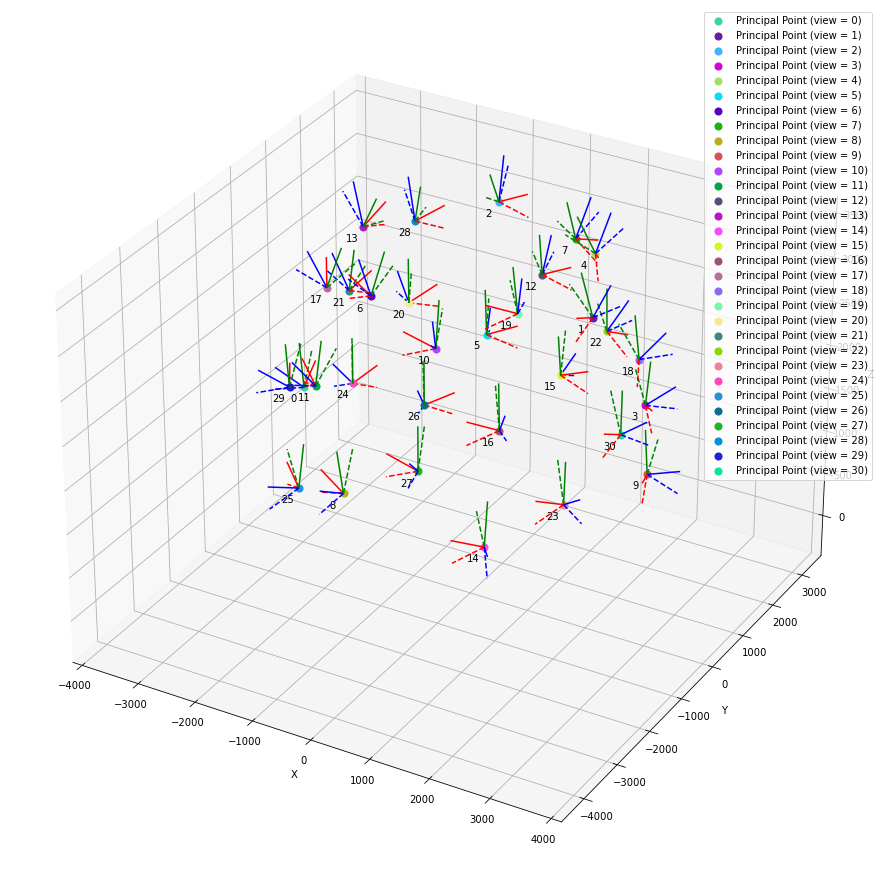

 => Sequence: 160224_haggling1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1335, -0.9905, -0.0333],
        [-0.0922,  0.0210, -0.9955],
        [ 0.9867,  0.1360, -0.0885]]) torch.Size([3, 3])
 ==> Translation: tensor([-2712.0901,  -188.4250,  1517.8500]) torch.Size([3])
 ==> Focal length X: 1632.8
 ==> Focal length Y: 1628.61
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 943.554
 ==> Principal print Y: 555.893
 ===> Principal point 2D Homogeneous: [943.554, 555.893] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6328e+03, 0.0000e+00, 9.4355e+02],
        [0.0000e+00, 1.6286e+03, 5.5589e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2711.1033,  -188.2890,  1517.7615])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0599,  

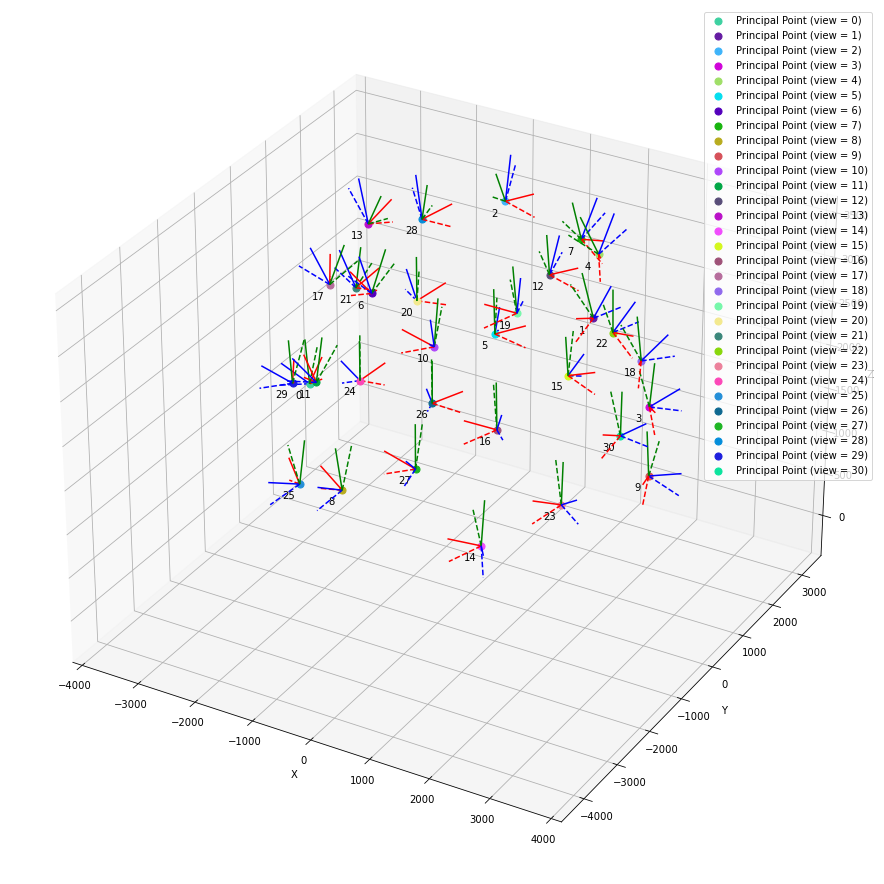

 => Sequence: 160226_haggling1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1148, -0.9928, -0.0334],
        [-0.0915,  0.0229, -0.9955],
        [ 0.9892,  0.1173, -0.0882]]) torch.Size([3, 3])
 ==> Translation: tensor([-2733.2700,  -110.4870,  1519.1000]) torch.Size([3])
 ==> Focal length X: 1634.07
 ==> Focal length Y: 1630.08
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 945.357
 ==> Principal print Y: 555.953
 ===> Principal point 2D Homogeneous: [945.357, 555.953] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6341e+03, 0.0000e+00, 9.4536e+02],
        [0.0000e+00, 1.6301e+03, 5.5595e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2732.2808,  -110.3697,  1519.0117])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0773, 

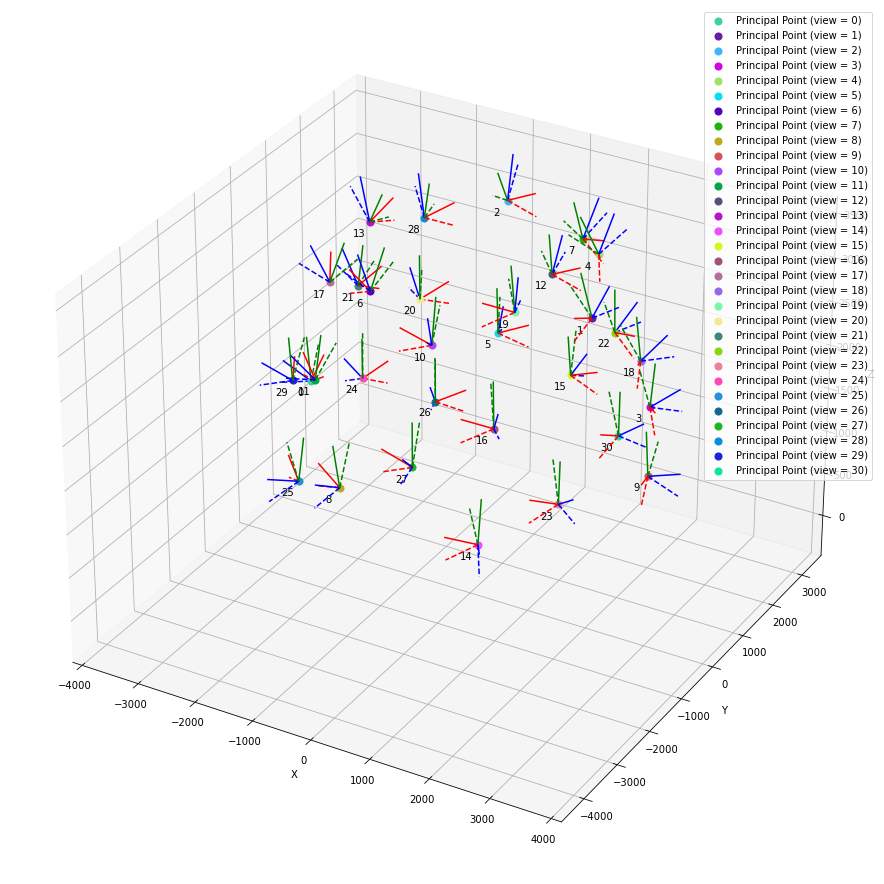

 => Sequence: 161202_haggling1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1473, -0.9885, -0.0334],
        [-0.0922,  0.0199, -0.9955],
        [ 0.9848,  0.1497, -0.0882]]) torch.Size([3, 3])
 ==> Translation: tensor([-2731.1599,  -264.9320,  1518.1000]) torch.Size([3])
 ==> Focal length X: 1633.34
 ==> Focal length Y: 1628.92
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 941.593
 ==> Principal print Y: 557.307
 ===> Principal point 2D Homogeneous: [941.593, 557.307] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6333e+03, 0.0000e+00, 9.4159e+02],
        [0.0000e+00, 1.6289e+03, 5.5731e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2730.1750,  -264.7823,  1518.0117])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0435, 

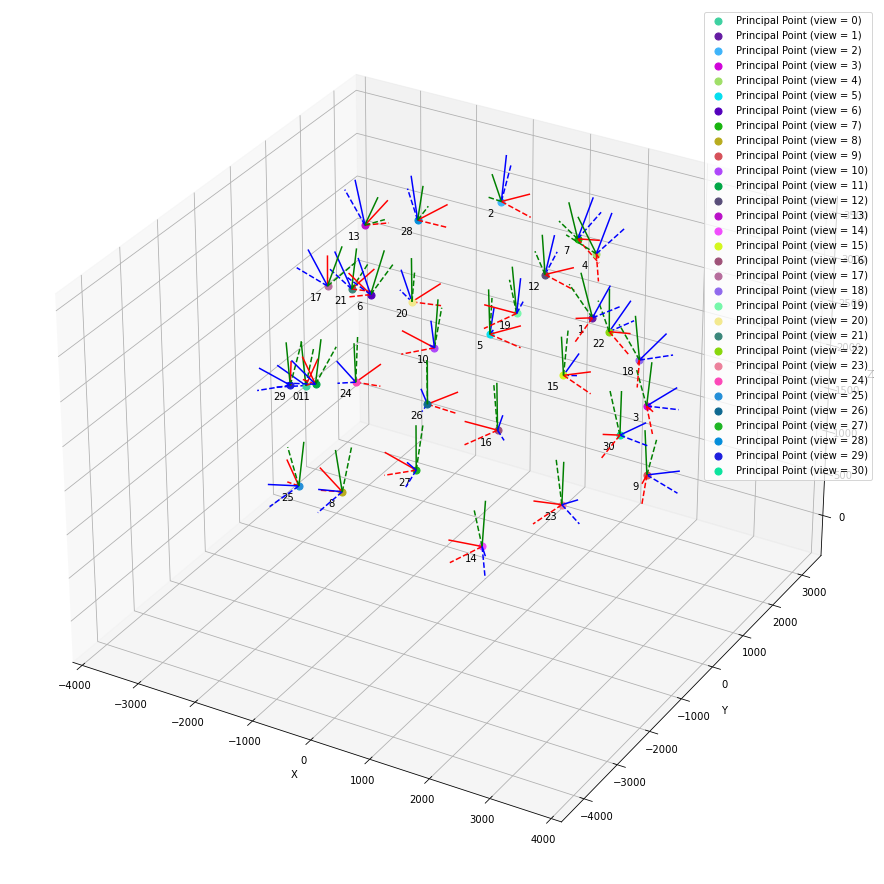

 => Sequence: 160906_ian1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1369, -0.9900, -0.0336],
        [-0.0902,  0.0213, -0.9957],
        [ 0.9865,  0.1394, -0.0864]]) torch.Size([3, 3])
 ==> Translation: tensor([-2706.6899,  -214.7480,  1518.3400]) torch.Size([3])
 ==> Focal length X: 1634.03
 ==> Focal length Y: 1629.73
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 942.792
 ==> Principal print Y: 558.29
 ===> Principal point 2D Homogeneous: [942.792, 558.29] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6340e+03, 0.0000e+00, 9.4279e+02],
        [0.0000e+00, 1.6297e+03, 5.5829e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2705.7034,  -214.6086,  1518.2535])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0534,  0.9983

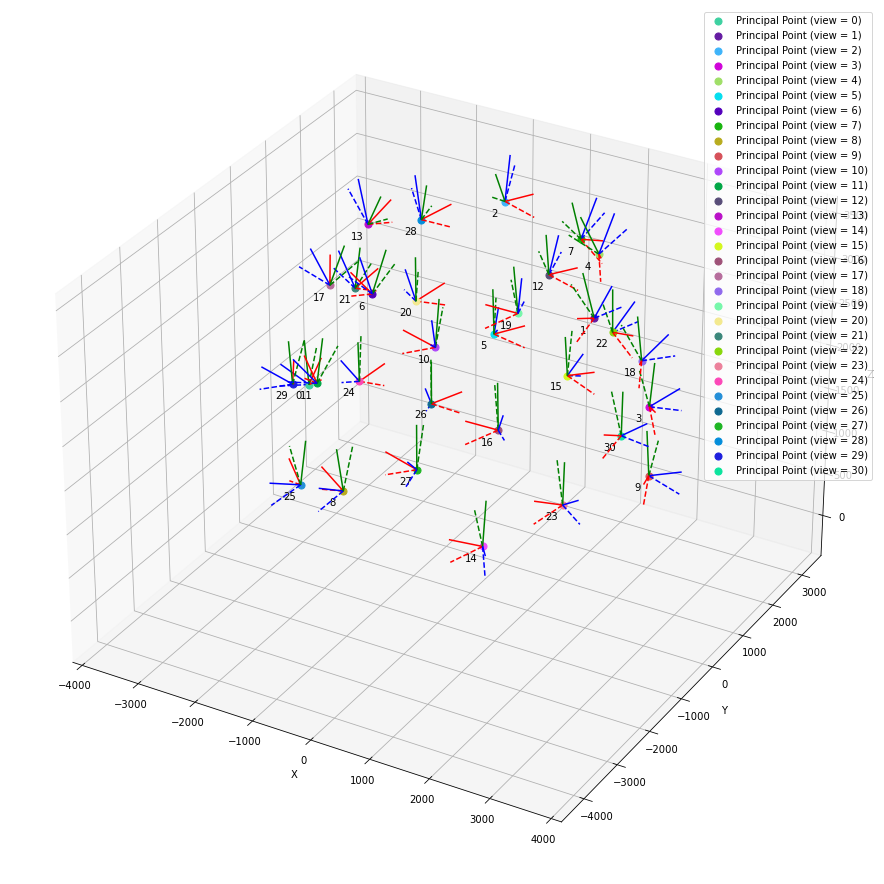

 => Sequence: 160906_ian2
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1369, -0.9900, -0.0336],
        [-0.0902,  0.0213, -0.9957],
        [ 0.9865,  0.1394, -0.0864]]) torch.Size([3, 3])
 ==> Translation: tensor([-2706.6899,  -214.7480,  1518.3400]) torch.Size([3])
 ==> Focal length X: 1634.03
 ==> Focal length Y: 1629.73
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 942.792
 ==> Principal print Y: 558.29
 ===> Principal point 2D Homogeneous: [942.792, 558.29] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6340e+03, 0.0000e+00, 9.4279e+02],
        [0.0000e+00, 1.6297e+03, 5.5829e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2705.7034,  -214.6086,  1518.2535])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0534,  0.9983

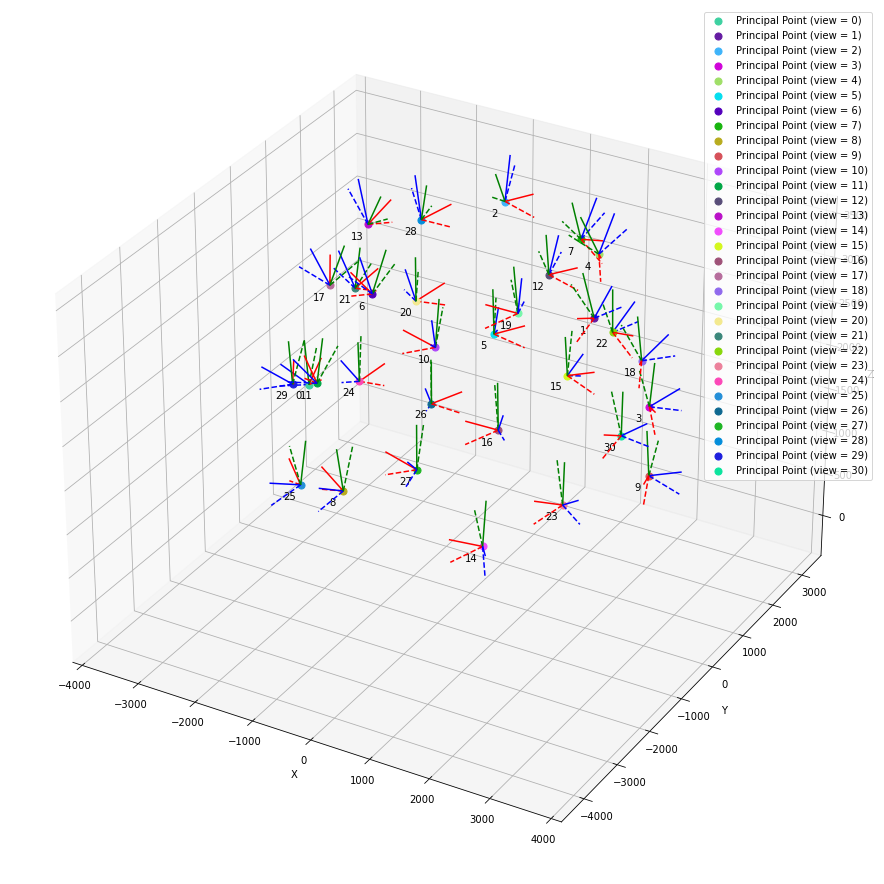

 => Sequence: 160906_ian3
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1369, -0.9900, -0.0336],
        [-0.0902,  0.0213, -0.9957],
        [ 0.9865,  0.1394, -0.0864]]) torch.Size([3, 3])
 ==> Translation: tensor([-2706.6899,  -214.7480,  1518.3400]) torch.Size([3])
 ==> Focal length X: 1634.03
 ==> Focal length Y: 1629.73
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 942.792
 ==> Principal print Y: 558.29
 ===> Principal point 2D Homogeneous: [942.792, 558.29] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6340e+03, 0.0000e+00, 9.4279e+02],
        [0.0000e+00, 1.6297e+03, 5.5829e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2705.7034,  -214.6086,  1518.2535])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0534,  0.9983

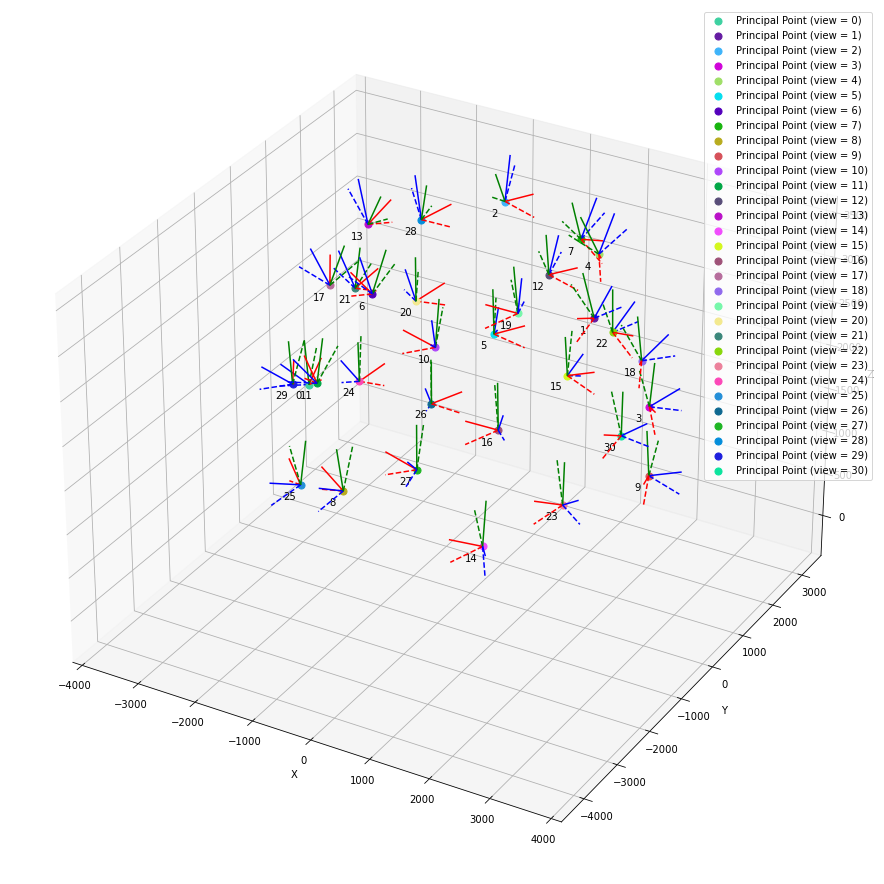

 => Sequence: 160906_band1
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1369, -0.9900, -0.0336],
        [-0.0902,  0.0213, -0.9957],
        [ 0.9865,  0.1394, -0.0864]]) torch.Size([3, 3])
 ==> Translation: tensor([-2706.6899,  -214.7480,  1518.3400]) torch.Size([3])
 ==> Focal length X: 1634.03
 ==> Focal length Y: 1629.73
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 942.792
 ==> Principal print Y: 558.29
 ===> Principal point 2D Homogeneous: [942.792, 558.29] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6340e+03, 0.0000e+00, 9.4279e+02],
        [0.0000e+00, 1.6297e+03, 5.5829e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2705.7034,  -214.6086,  1518.2535])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0534,  0.998

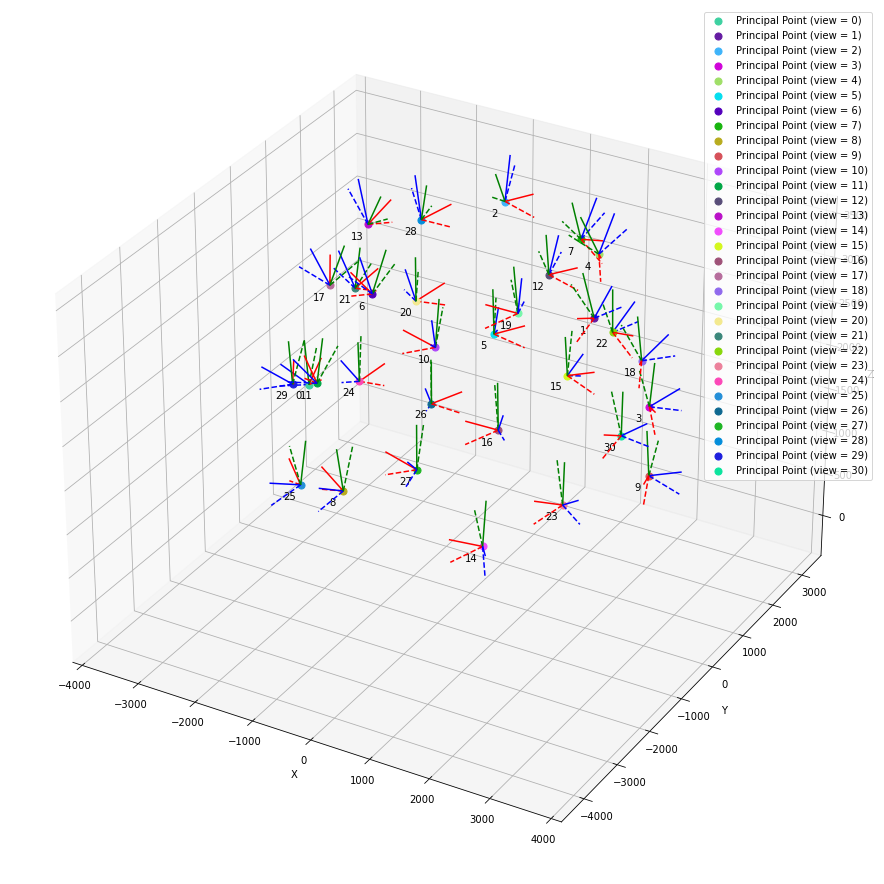

 => Sequence: 160906_band2
 => Num of views: 31
 => Cam list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


 ==> View: 0
 ==> Color: #3ed1a1
 ==> Rotation: tensor([[ 0.1369, -0.9900, -0.0336],
        [-0.0902,  0.0213, -0.9957],
        [ 0.9865,  0.1394, -0.0864]]) torch.Size([3, 3])
 ==> Translation: tensor([-2706.6899,  -214.7480,  1518.3400]) torch.Size([3])
 ==> Focal length X: 1634.03
 ==> Focal length Y: 1629.73
 ==> Skew Coefficient: 0.0
 ==> Principal print X: 942.792
 ==> Principal print Y: 558.29
 ===> Principal point 2D Homogeneous: [942.792, 558.29] torch.Size([3])
 ===> Intrinsic matrix: tensor([[1.6340e+03, 0.0000e+00, 9.4279e+02],
        [0.0000e+00, 1.6297e+03, 5.5829e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) torch.Size([3, 3])
 ===> World coordinates of principal point: tensor([-2705.7034,  -214.6086,  1518.2535])
 ==> View: 1
 ==> Color: #651ca2
 ==> Rotation: tensor([[ 0.0534,  0.998

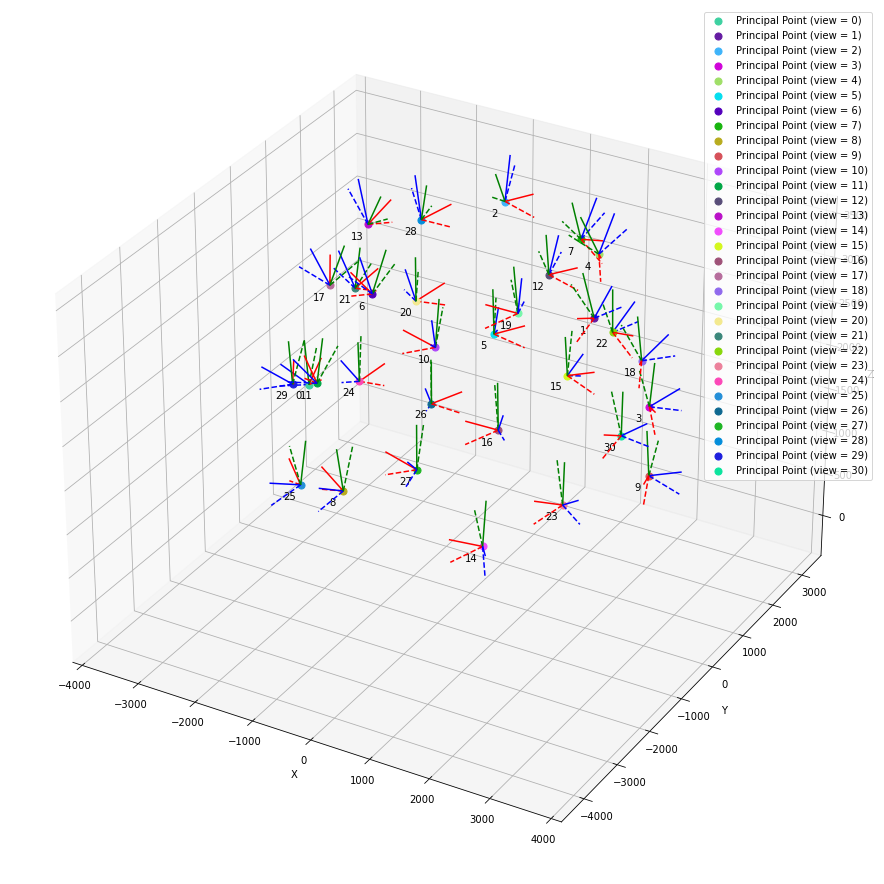

In [21]:
for i, seq in enumerate(cameras.keys()):
    
    # Create a 3D 
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')

    # Set plot limits
    x_mul = 1
    y_mul = 1
    z_mul = 2
#     ax.set_xlim(space_center[0] - space_size[0] / 2, space_center[0] + space_size[0] / 2)
#     ax.set_ylim(space_center[1] - space_size[1] / 2, space_center[1] + space_size[1] / 2)
#     ax.set_zlim(space_center[2] - space_size[2] / 2, space_center[2] + space_size[2] / 2)
    ax.set_xlim((space_center[0] - space_size[0] / 2) * x_mul, (space_center[0] + space_size[0] / 2) * x_mul)
    ax.set_ylim((space_center[1] - space_size[1] / 2) * y_mul, (space_center[1] + space_size[1] / 2) * y_mul)
    ax.set_zlim((space_center[2] - space_size[2] / 2) * z_mul, (space_center[2] + space_size[2] / 2) * z_mul)

    # Set plot labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')    
    
    print('='*50)
    print(' => Sequence:', seq)
    print(' => Num of views:', len(cameras[seq]))
    print(' => Cam list:', cam_list)    
    print()
    print()
    
    for view_id, view_num in enumerate(cam_list):
        
        cam = cameras[seq][view_id]
        R_matrix = torch.tensor(cam['R'], dtype=torch.float32)
        translation = torch.tensor(cam['T'], dtype=torch.float32).squeeze()
        focal_length_x = cam['fx']
        focal_length_y = cam['fy']
        skew = cam['s']
        principal_point_x = cam['cx']
        principal_point_y = cam['cy']
        
        color=random_colors[view_id]
        
        print('='*25)
        print('='*15)
        print(' ==> View:', view_num)
        print(' ==> Color:', color)
        print(' ==> Rotation:', R_matrix, R_matrix.shape)
        print(' ==> Translation:', translation, translation.shape)
        print(' ==> Focal length X:', focal_length_x)
        print(' ==> Focal length Y:', focal_length_y)
        print(' ==> Skew Coefficient:', skew)
        print(' ==> Principal print X:', principal_point_x)
        print(' ==> Principal print Y:', principal_point_y)
        print('='*15)
        
        # Plot cameras
        plot_camera(ax, view_num, R_matrix, translation, focal_length_x, focal_length_y, skew, principal_point_x, principal_point_y, \
                    arrow_length_ratio=500, s=50, color=color)

        print('='*15)

    # Display the plot
    plt.legend()
    plt.show()
        
    print('='*50)